# A Credit Card Frauds analysis
## Always look at your data

In today's digital life, day by day, more and more, we buy online. Clothes, perfumes, home appliances, basically everything seems sellable on the internet at a lower price. Most of the times, we use our credit cards for our purchases, and we need to be confident that our data won't be catched by cyber-attackers. This confidence is crucial for the whole sector because, if it goes away, people will stop buying online. So we need to protect those data and we need to be able to distinguish the shady transactions from the good ones.

The dataset we're gonna use, released on <em>Kaggle</em>, contains transactions made by credit cards in September 2013 by European cardholders. It presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In this notebook, we will explore the credit card frauds issue, and we will do it using neural network models. In the first part, we will use the <b>Autoencoder</b> model. An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. Our idea is that, if we train this network on regular transactions, the moment the model will see some fraudulent transactions, it will show a different reconstruction loss. If this happen, we'll have a tool that we can use to distinguish 'bad' from 'good' transactions. In the second part, we will build a simple and theoretically meaningless model, that we called, just to play, <i>BalloonNet</i> because of its shape, and we will see how with this, with a shorter training, we will get better results. In the last part, we will find an <u>explanation</u> for this apparently crezy behaviour, ending up our analysis with an old but always good lesson.

Let's start!

In [1]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import os

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

## Data

In [2]:
# loading data

df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The amount of the frauds varys between 0 and 25,691 dollars. Values in V1:V28 are positive and negative one digit numbers. Time is a counter and goes from 0 to 172792. Class is 0 (for no fraud) and 1 (for fraud). Let's check how unbalanced are these data:

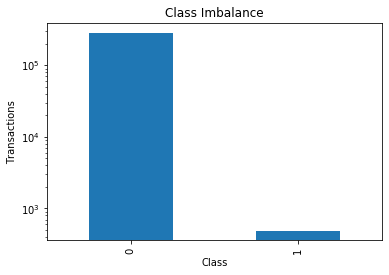

In [5]:
df.groupby('Class')['Class'].count().plot.bar(logy=True)
plt.title('Class Imbalance')
plt.xlabel('Class')
plt.ylabel('Transactions')
plt.show();

The dataset is pretty unbalanced. Let's check the numbers:

In [6]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Considering that 0 means <em>regular</em> transactions and 1 means <em>fraudolent</em> transactions, in our dataset we have one fraud every 579 transactions. This can actually be an issue and forces us not to use accuracy as a metric - we would get a 99.8% accuracy simply claiming that every transaction is legit. There are strategies we can use though. One is to add syntethically created frauds to our data to rebalance our dataset. But what we'll be trying in this notebook is to go on without frauds data, and we'll do it with a very simple and old model, called Autoencoder.<br>

Autoencoders were introduced in the 80s by <em>Hinton et al</em>. They are mostly used for dimensionality reduction and data denoising. But another use of them is <u>anomaly detection</u>, and frauds are, from many points of view, anomalies. What is interesting is that we won't use our frauds to train our networks, but we will use just the data related to our regular transactions.

## Preprocessing

There is not much we need to do to be able to work on this dataset. We will split it in features and target, in doing so, we will drop the Time and Amount columns, even though we can't claim that they are meaningless for our purpose. We will split again in fraudulent and regular transactions - remember we'll be using just regular transactions for training our model. We'll extract some regular transaction, the same number of the frauds, to build a small dataset we'll be using to test our model.

In [7]:
# splitting the dataset into X features and y target

X = df.drop(['Time', 'Class', 'Amount'], axis=1)
y = df['Class']

In [8]:
# splitting data in regular and fraudulent transactions

X_normal = X[y==0].values
X_fraud = X[y==1].values

In [9]:
# reserving some regular transactions for our tests
# the number of them is the same of the fraudulent ones
# of course, we're gonna be removing them from the training data

frauds_nr = X_fraud.shape[0]
normal_ixs = np.random.randint(0, X_normal.shape[0], frauds_nr)
normal_ixs.shape
X_test = np.concatenate((X_normal[normal_ixs], X_fraud))
y_test = np.concatenate((np.zeros(frauds_nr), np.ones(frauds_nr)))
shuffle_ixs = np.arange(frauds_nr*2)
np.random.shuffle(shuffle_ixs)
X_test = X_test[shuffle_ixs]
y_test = y_test[shuffle_ixs]
X_sc_normal = np.delete(X_normal, normal_ixs, axis=0)

Okay, our preprocessing job is over. As you should be able to see, this is a very basic introductory job. We will train our Autoencoder with the <em>regular</em> transactions and then evaluate it with a mixed dataset, with half regular and half <em>fraudulent</em> transactions. Our hope is to find a sensibly different reconstruction loss between regular and irregular transactions.

## 1. Autoencoder

In order to build our autoencoder, we will make use of the tensorflow <em>Functional API</em>. The functional API in tensorflow.keras is a way to create models that are more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs. The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers.

In [10]:
features_num = X.shape[1]

In [11]:
# build_encoder function

def build_encoder(features):
    i = tf.keras.Input(shape = (features,))
    e = tf.keras.layers.Dense(64, activation= 'relu')(i)
    e = tf.keras.layers.Dense(32, activation= 'relu')(e)
    e = tf.keras.layers.Dense(16, activation = 'relu')(e)
    e = tf.keras.layers.Dense(8, activation = 'relu')(e)
    e = tf.keras.layers.Dense(4, activation='relu')(e)
    e = tf.keras.layers.Dense(2, activation='relu')(e)
    return i, e

In [12]:
# build decoder function

def build_decoder(en_output, features):
    d = tf.keras.layers.Dense(4, activation='relu')(en_output)
    d = tf.keras.layers.Dense(8, activation='relu')(d)
    d = tf.keras.layers.Dense(16, activation='relu')(d)
    d = tf.keras.layers.Dense(32, activation='relu')(d)
    d = tf.keras.layers.Dense(64, activation= 'relu')(d)
    o = tf.keras.layers.Dense(features)(d)
    return o

In [13]:
# building autoencoder

def build_autoencoder(features):
    i, e = build_encoder(features)
    o = build_decoder(e, features)
    return tf.keras.Model(inputs=i, outputs=o)

In [14]:
autoencoder = build_autoencoder(features_num)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1856      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10    

In [15]:
# compiling the model

autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [16]:
# training the model

history = autoencoder.fit(X_normal, X_normal, batch_size=32, 
                              epochs=20, shuffle=True, validation_split=0.1)

Epoch 1/20
7997/7997 [==============================] - 15s 2ms/step - loss: 0.6465 - accuracy: 0.4569 - val_loss: 0.5770 - val_accuracy: 0.5587
Epoch 2/20
7997/7997 [==============================] - 13s 2ms/step - loss: 0.5149 - accuracy: 0.5218 - val_loss: 0.4372 - val_accuracy: 0.6522
Epoch 3/20
7997/7997 [==============================] - 13s 2ms/step - loss: 0.4734 - accuracy: 0.5331 - val_loss: 0.4071 - val_accuracy: 0.6508
Epoch 4/20
7997/7997 [==============================] - 14s 2ms/step - loss: 0.4578 - accuracy: 0.5378 - val_loss: 0.4749 - val_accuracy: 0.6311
Epoch 5/20
7997/7997 [==============================] - 15s 2ms/step - loss: 0.4443 - accuracy: 0.5390 - val_loss: 0.3867 - val_accuracy: 0.6352
Epoch 6/20
7997/7997 [==============================] - 13s 2ms/step - loss: 0.4357 - accuracy: 0.5410 - val_loss: 0.3889 - val_accuracy: 0.6402
Epoch 7/20
7997/7997 [==============================] - 12s 2ms/step - loss: 0.4359 - accuracy: 0.5381 - val_loss: 0.3981 - val_ac

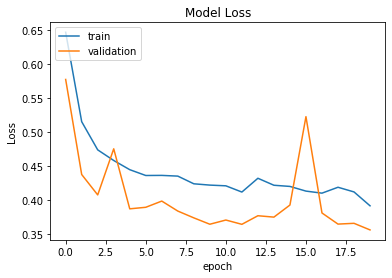

In [17]:
#  plot loss and val_loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

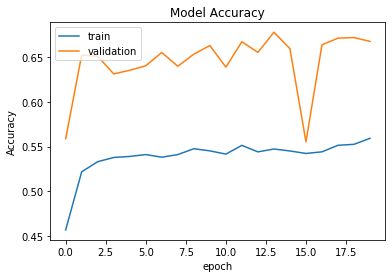

In [18]:
#  plot accuracy and val_accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

This model reaches a 66.7% accuracy on the validation set, with regular transactions. We've been able to encode and decode our data, reducing a 28 features dimension into a 2 dimension, and then back, with a loss of 0.356. I would say that the result is so and so, but now we want to see if this autoencoder can still catch the <em>bad</em> transactions on the test set we've already built, containing half regular and half fraudulent transactions. It's a small dataset but it should be able to do its job.

### Anomaly Detection

In [19]:
# passing the test set to the autoencoder

reconstructions = autoencoder.predict(X_test)

In [20]:
# calculating mse reconstruction loss per row

rec_mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

In [21]:
regular = rec_mse[y_test==0]
fraud = rec_mse[y_test==1]

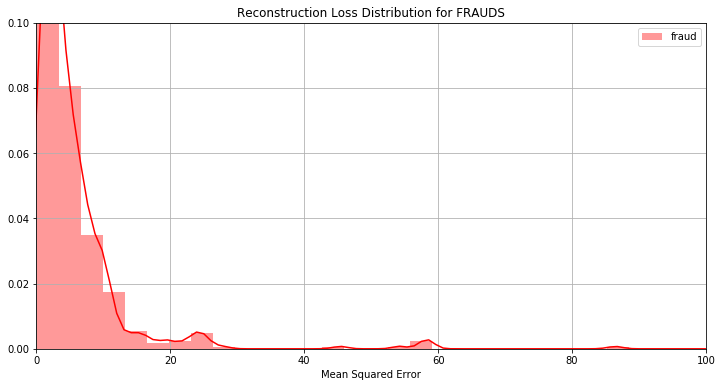

In [23]:
# plotting frauds MSE distribution

fig, ax1 = plt.subplots(figsize=(12,6))
sns.distplot(fraud, bins=40, label="fraud", color="red", kde=True, ax=ax1)
plt.xlim([0, 100])
plt.ylim([0, 0.1])
plt.title("Reconstruction Loss Distribution for FRAUDS")
plt.xlabel("Mean Squared Error")
plt.grid()
plt.legend()
plt.show();

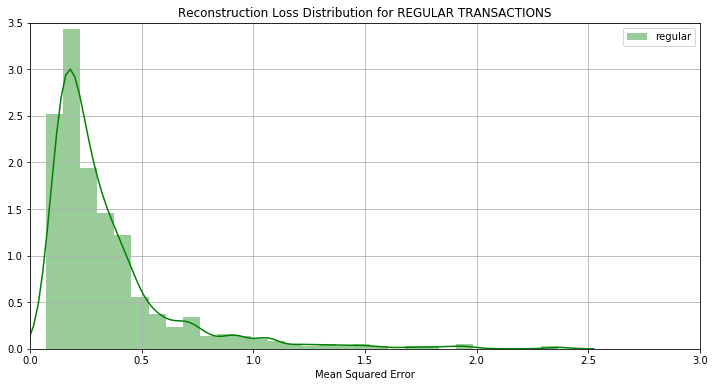

In [28]:
# plotting regular transactions MSE distribution

fig, ax2 = plt.subplots(figsize=(12,6))
sns.distplot(regular, bins=30, label="regular", color="green", kde=True, ax=ax2)
plt.xlim([0, 3])
plt.ylim([0, 3.5])
plt.title("Reconstruction Loss Distribution for REGULAR TRANSACTIONS")
plt.xlabel("Mean Squared Error")
plt.grid()
plt.legend()
plt.show();

As we may see, regular and fraudulent transactions show a different <b>mse</b>. This means that our network is not able to reconstruct efficiently frauds. So, using autoencoders, we may get a way to distinguish between good and bad transactions, raising a red flag when transactions are shady. We finish this part, by showing some number:

In [41]:
print("Number of regular transactions signaled as suspicious: ", sum(regular>1.2))
print("Percentage of regular transactions signaled as suspicious: ", 
      str(round((sum(regular>=1.2)/492)*100, 2))+"%")

Number of regular transactions signaled as suspicious:  13
Percentage of regular transactions signaled as suspicious:  2.64%


In [42]:
print("Number of fraudulent transactions signaled as suspicious: ", sum(fraud>1.2))
print("Percentage of fraudulent transactions signaled as suspicious: ", 
      str(round((sum(fraud>1.2)/492)*100, 2))+"%")

Number of fraudulent transactions signaled as suspicious:  413
Percentage of fraudulent transactions signaled as suspicious:  83.94%


With a couple of minutes of experiments to find a good number, we are able to catch almost 84% of frauds, using a simple autoencoder. All this with just 13 <em>false alarms</em>. This looks like a great result. Now, what is really interesting is to show how we can get results even better with a simple and counterintuitive model, and this is what we will see in the next chapter.

## 2. BalloonNet

In [43]:
# building a weird model and checking its architecture

balloon_net = tf.keras.Sequential([
    tf.keras.layers.Dense(60, activation='relu', input_shape=(features_num,)),
    tf.keras.layers.Dense(features_num)
])

balloon_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 60)                1740      
_________________________________________________________________
dense_13 (Dense)             (None, 28)                1708      
Total params: 3,448
Trainable params: 3,448
Non-trainable params: 0
_________________________________________________________________


In [44]:
# compiling the model

balloon_net.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [45]:
# training this model with for just 5 epochs

history_bn = balloon_net.fit(X_normal, X_normal, batch_size=32, epochs=5, shuffle=True, validation_split=0.1)

Epoch 1/5
7997/7997 [==============================] - 8s 996us/step - loss: 0.0424 - accuracy: 0.9229 - val_loss: 0.0040 - val_accuracy: 0.9614
Epoch 2/5
7997/7997 [==============================] - 9s 1ms/step - loss: 0.0012 - accuracy: 0.9856 - val_loss: 1.6752e-04 - val_accuracy: 0.9959
Epoch 3/5
7997/7997 [==============================] - 8s 992us/step - loss: 0.0013 - accuracy: 0.9863 - val_loss: 2.6905e-04 - val_accuracy: 0.9906
Epoch 4/5
7997/7997 [==============================] - 8s 1ms/step - loss: 0.0011 - accuracy: 0.9878 - val_loss: 0.0034 - val_accuracy: 0.9688
Epoch 5/5
7997/7997 [==============================] - 10s 1ms/step - loss: 0.0012 - accuracy: 0.9875 - val_loss: 0.0017 - val_accuracy: 0.9874


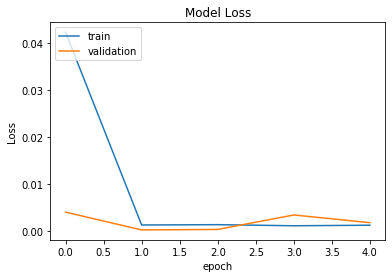

In [46]:
#  plot loss and val_loss

plt.plot(history_bn.history['loss'])
plt.plot(history_bn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

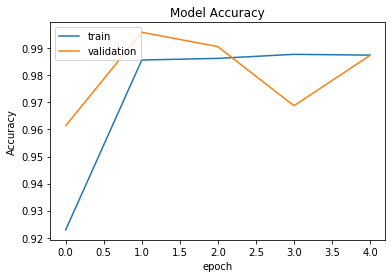

In [47]:
#  plot accuracy and val_accuracy

plt.plot(history_bn.history['accuracy'])
plt.plot(history_bn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

Now, obviously this model shows high accuracy - around 99% on validation set - and basically 0 loss. But this is just logical. The hidden layer is larger than input and output, the model can simply replicate the data in half the available space. Let's test this model with the test set we used with the autoencoder:

In [48]:
# passing the test set to the ballon_net
reconstructions_bn = balloon_net.predict(X_test)

# calculating mse reconstruction loss per row
rec_mse_bn = np.mean(np.power(X_test - reconstructions_bn, 2), axis=1)

# creating 2 df with regular and fraudulent transactions
regular_bn = rec_mse_bn[y_test==0]
fraud_bn = rec_mse_bn[y_test==1]

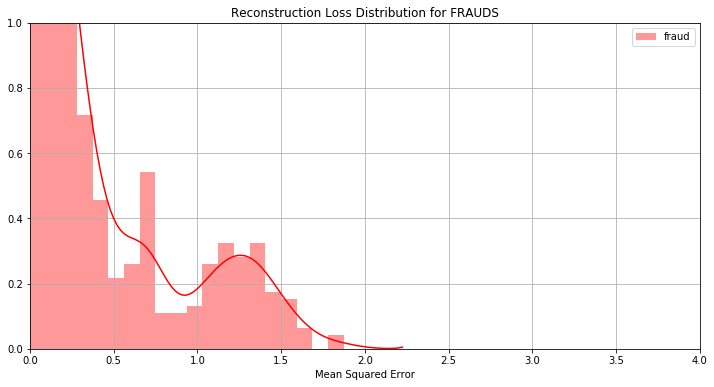

In [50]:
# plotting frauds MSE distribution with our new model

fig, ax1 = plt.subplots(figsize=(12,6))
sns.distplot(fraud_bn, bins=20, label="fraud", color="red", kde=True, ax=ax1)
plt.xlim([0, 4])
plt.ylim([0, 1])
plt.title("Reconstruction Loss Distribution for FRAUDS")
plt.xlabel("Mean Squared Error")
plt.grid()
plt.legend()
plt.show();

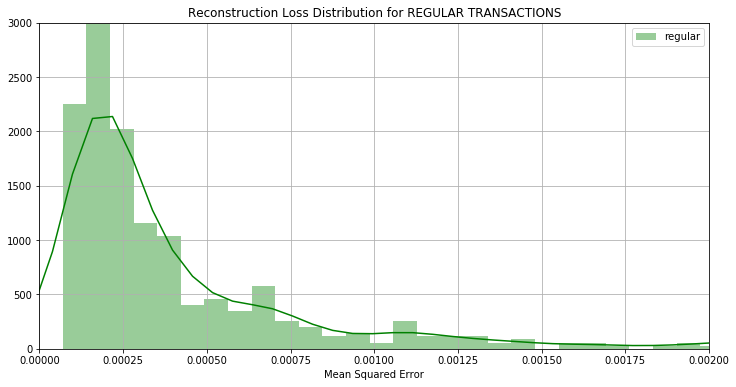

In [60]:
# plotting regular transactions MSE distribution

fig, ax2 = plt.subplots(figsize=(12,6))
sns.distplot(regular_bn, bins=100, label="regular", color="green", kde=True, ax=ax2)
plt.xlim([0, 0.002])
plt.ylim([0, 3000])
plt.title("Reconstruction Loss Distribution for REGULAR TRANSACTIONS")
plt.xlabel("Mean Squared Error")
plt.grid()
plt.legend()
plt.show();

What we are seeing now is interesting, our model shows a pretty different behaviour with regular and fraudulent transactions. Clearly it remains perfectly capable to reconstruct regular inputs, but it still shows some error when facing fraudulent ones. Now, remember that we didn't communicate it in any way their different nature Let's see if we can investigate furtherly, for example taking a look at the latent space codification.

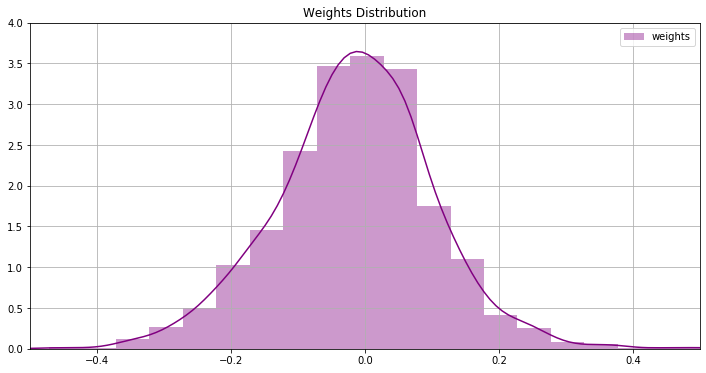

In [62]:
# plotting regular transactions MSE distribution

weights = np.array(balloon_net.layers[0].get_weights()[0]).flatten().tolist()
fig, ax3 = plt.subplots(figsize=(12,6))
sns.distplot(weights, bins=20, label="weights", color="purple", kde=True, ax=ax3)
plt.xlim([-0.5, 0.5])
plt.ylim([0, 4])
plt.title("Weights Distribution")
plt.grid()
plt.legend()
plt.show();

The weights of our model are normally distribuited. Let's check mean and standard deviation:

In [63]:
print("The mean of our weights is: ", np.mean(weights))
print("The standard deviation is: ", np.std(weights))

The mean of our weights is:  -0.015648351386228873
The standard deviation is:  0.11820297071971167


The mean is around 0, standard deviation 0.12. Until now, nothing too weird. Let's check the latent representation. In order to do it, we will build a new network with just the first layer of our ballon net. We will pass the weights we already have.

In [64]:
half_balloon_net = tf.keras.Sequential([
   tf.keras.layers.Dense(60, activation='relu', 
                         weights=balloon_net.layers[0].get_weights(), 
                         input_shape=(features_num,)) 
])

latent_rep = half_balloon_net.predict(X_test)

In [65]:
# preprocessing

test_reg = X_test[y_test==0]
test_frd = X_test[y_test==1]
repr_reg = latent_rep[y_test==0]
repr_frd = latent_rep[y_test==1]
test_reg = np.array(test_reg).flatten().tolist()
test_frd = np.array(test_frd).flatten().tolist()
repr_reg = np.array(repr_reg).flatten().tolist()
repr_frd = np.array(repr_frd).flatten().tolist()

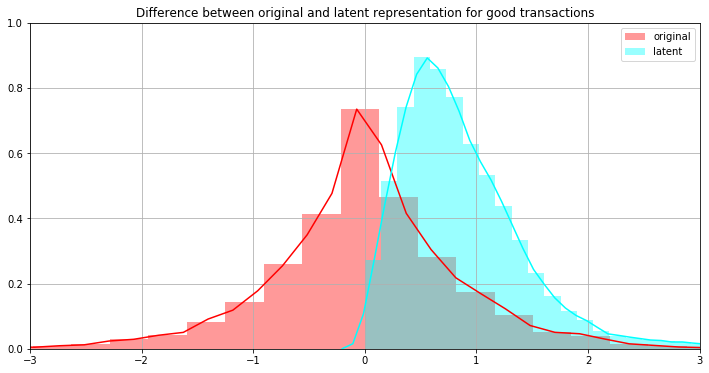

In [68]:
fig, ax3 = plt.subplots(figsize=(12,6))
sns.distplot(test_reg, bins=80, label="original", color="red", ax=ax3)
sns.distplot(repr_reg, bins=80, label="latent", color="cyan", ax=ax3)
plt.xlim([-3, 3])
plt.ylim([0, 1])
plt.title("Difference between original and latent representation for good transactions")
plt.grid()
plt.legend()
plt.show();

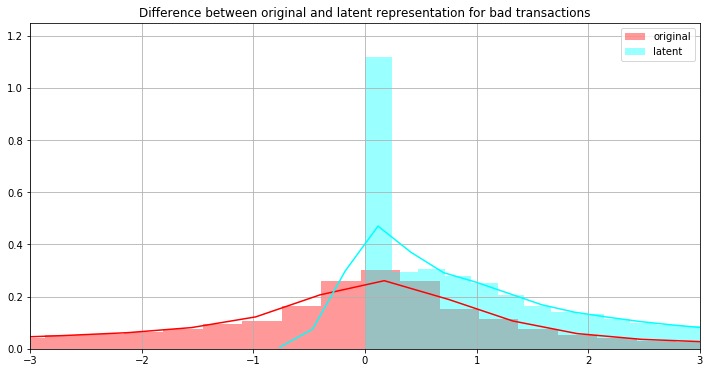

In [70]:
fig, ax4 = plt.subplots(figsize=(12,6))
sns.distplot(test_frd, bins=200, label="original", color="red", ax=ax4)
sns.distplot(repr_frd, bins=150, label="latent", color="cyan", ax=ax4)
plt.xlim([-3, 3])
plt.ylim([0, 1.25])
plt.title("Difference between original and latent representation for bad transactions")
plt.grid()
plt.legend()
plt.show();

The main difference we can see is that, using a ReLU activation, our latent values are positive. In the next, final and super short, chapter we will take another look at the data we are analysing, discovering why even the dumbest of the NNs shows unsuspected prediction abilities.

## 3. Explanation and Conclusion

Eventually we got the suspect that our data are somehow explicative by themselves. Let's perform a couple of tests to see if our ideas are somehow motivated. Let's start checking the means of input and hidden layer for regular transactions:

In [76]:
print('Mean of test set values for regular transactions: ', np.mean(test_reg))
print('Mean of test set latent representations for regular transactions: ', np.mean(repr_reg))

Mean of test set values for regular transactions:  0.001021813875340537
Mean of test set latent representations for regular transactions:  0.8706639387738212


As we could imagine, the ReLU activation shifted the values. What about the standard deviations?

In [79]:
print('Standard deviation of test set values for regular transactions: ', np.std(test_reg))
print('Standard deviation of test set latent representations for regular transactions: ', np.std(repr_reg))

Standard deviation of test set values for regular transactions:  0.9434167508988325
Standard deviation of test set latent representations for regular transactions:  0.6023197230957159


Time to check the fraudulent transactions:

In [80]:
print('Mean of test set values for fraudulent transactions: ', np.mean(test_frd))
print('Mean of test set latent representations for fraudulent transactions: ', np.mean(repr_frd))
print()
print('Standard deviation of test set values for fraudulent transactions: ', np.std(test_frd))
print('Standard deviation of test set latent representations for fraudulent transactions: ', np.std(repr_frd))

Mean of test set values for fraudulent transactions:  -1.505545139913973
Mean of test set latent representations for fraudulent transactions:  2.147560713460876

Standard deviation of test set values for fraudulent transactions:  5.093266407928514
Standard deviation of test set latent representations for fraudulent transactions:  3.1793555945859673


Okay, time to show the trick of our magic. What about the values in our original dataset, splitted by regular and fraudulent transactions?

In [86]:
print('Mean and standard deviation of our regular transactions: ', np.mean(X_normal), np.std(X_normal))

Mean and standard deviation of our regular transactions:  0.0026053082279791553 1.0250079877579472


In [87]:
print('Mean and standard deviation of our fraudulent transactions: ', np.mean(X_fraud), np.std(X_fraud))

Mean and standard deviation of our fraudulent transactions:  -1.5055451399139732 5.093266407928514


In [88]:
from scipy.stats import shapiro
stat, p = shapiro(X_normal)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("X_normal follows Normal Distribution")
else:
    print("X_normal doesn't follow Normal Distribution")

stat=0.851, p=0.000
X_normal doesn't follow Normal Distribution


/Users/maurizioscibilia/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [89]:
from scipy.stats import shapiro
stat, p = shapiro(X_fraud)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("X_fraud follows Normal Distribution")
else:
    print("X_fraud doesn't follow Normal Distribution")

stat=0.828, p=0.000
X_fraud doesn't follow Normal Distribution


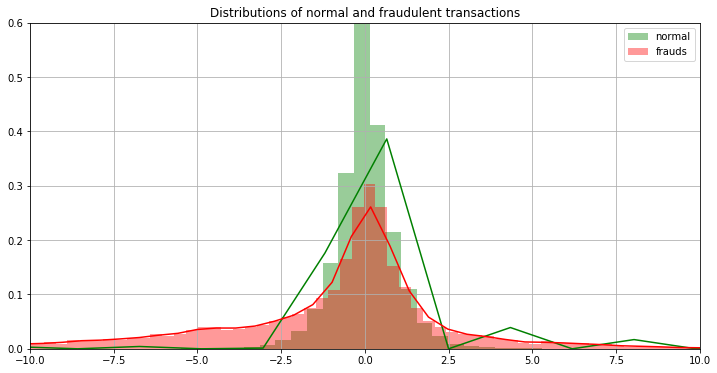

In [95]:
fig, ax5 = plt.subplots(figsize=(12,6))
sns.distplot(X_normal, bins=500, label="normal", color="green", ax=ax5)
sns.distplot(X_fraud, bins=200, label="frauds", color="red", ax=ax5)
plt.xlim([-10, 10])
plt.ylim([0, 0.6])
plt.title("Distributions of normal and fraudulent transactions")
plt.grid()
plt.legend()
plt.show();